<a href="https://colab.research.google.com/github/ykitaguchi77/GravCont_classification_colab/blob/master/Eye_crop_bilateral_1.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#顔の画像から目を検出して切り抜くスクリプト
・Haarcascade_eyeを使用<br>
・目が検出できないものはskipする<br>
・横幅を2倍、縦幅を上に1倍追加/下に0.5倍追加して画像を切り取る（目の全幅、眉毛が含まれるように）

・切り取った画像を250px*250pxにresizeする<br>
・対応表をCSV形式で出力（連番、左右、元フォルダ、元画像名）

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
import csv
from random import randint
from time import sleep
import numpy as np
import sys

import glob
import random
from PIL import Image
%matplotlib inline

#サポートパッチのインポート
from google.colab.patches import cv2_imshow
import cv2

plt.ion()   # interactive mode

#Google colabをマウント

In [1]:
'''
・dlibを用いて目を切り抜く
・横幅を2倍、縦幅を上に1倍追加/下に0.5倍追加して画像を切り取る（目の全幅、眉毛が含まれるように）
'''

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
#残り時間確認
!cat /proc/uptime | awk '{printf("残り時間 : %.2f", 12-$1/60/60)}'


残り時間 : 11.68

In [8]:
#元画像
in_path = '/content/drive/MyDrive/Deep_learning/Face_Images/IMG_3110.JPG'

#保存先フォルダ
out_path = '/content/drive/My Drive/Deep_learning/eyelid_images/IMG_3110_eye.JPG'


#Haarcascadeを指定

In [9]:
# カスケードファイルのパス
eye_cascade_path = '/content/drive/My Drive/Deep_learning/haarcascade_eye.xml'

# カスケード分類器の特徴量取得
eye_cascade = cv2.CascadeClassifier(eye_cascade_path)

In [10]:
#アスペクト比を維持したまま横を400pixelに縮小する
def scale_to_width(img, width):
    scale = width / img.shape[1]
    return cv2.resize(img, dsize=None, fx=scale, fy=scale)

#図を表示する
def show_image(img):
    #img = cv2.imread(out_path)
    dst = scale_to_width(img, 400)
    cv2_imshow(dst)

def my_round(val, digit=0):
    p = 10 ** digit
    return int((val * p * 2 + 1) // 2 / p)

image path =  /content/drive/MyDrive/Deep_learning/Face_Images/IMG_3110.JPG
目が2個検出されました
[[1247 1189  436  436]
 [ 596 1278  424  424]]
[ex,ey] = 1247,1189 [ew,eh] = 436,436
top:1080, bottom:1734, left:1138, right:1792
height:654, width:654


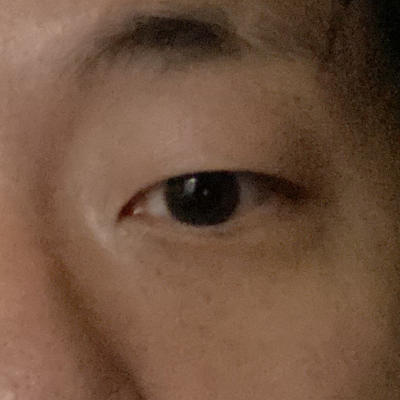

[ex,ey] = 596,1278 [ew,eh] = 424,424
top:1172, bottom:1808, left:490, right:1126
height:636, width:636


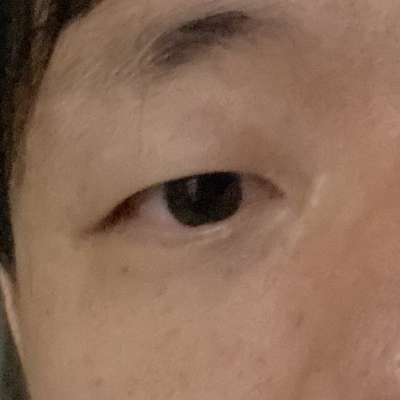

In [13]:
img = cv2.imread(in_path) 
img2 = img.copy()

# 画像グレースケール化
grayscale_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

#300pix以上のもので目に見えるものを抽出
eye_list = eye_cascade.detectMultiScale(grayscale_img, minSize=(300, 300))
print('image path = ',in_path)

# 眼検出判定
if len(eye_list) >= 1:
    print('目が' + str(len(eye_list)) +'個検出されました')
    pass
else:
    print("no eye detected")
    sys.exit()


print(eye_list)

#画像の切り抜きと保存（連番にする）

for (ex, ey, ew, eh) in eye_list:
    print("[ex,ey] = %d,%d [ew,eh] = %d,%d" %(ex, ey, ew, eh))
    
    try:
      cv2.rectangle(img2, (ex, ey), (ex + ew, ey + eh), (0, 255, 0), 2)

      #切り抜き範囲が元画像をはみ出る場合は黒画像で埋める
      top = max(0, ey-int(eh/4))
      bottom = min(grayscale_img.shape[0], int(ey + eh*5/4))
      left = max(0,int(ex-int(ew/4)))
      right = min(grayscale_img.shape[1], int(ex + ew*5/4))

      print(f"top:{top}, bottom:{bottom}, left:{left}, right:{right}")

      img_cropped = img[top: bottom,left:right]
      height, width = img_cropped.shape[:2]


      print(f"height:{height}, width:{width}")
      if width==height:
          img_background =img_cropped
      elif width>height:
          img_background = np.zeros((width,width,3), dtype = np.uint8)
          img_background[0:width, my_round((width-height)/2) :int(((width+height)/2)+height)]=img_cropped
      elif width<height:
          img_background = np.zeros((height,height,3), dtype = np.uint8)
          img_background[0:height, my_round((height-width)/2) :int(((height-width)/2)+width)]=img_cropped
      
      img_resized = cv2.resize(img_background,(1000,1000)) #1辺250pixにresize 

      show_image(img_resized)



    except:
      print('crop error')

    if ex <= grayscale_img.shape[1]/2:
        side = 0 #600ピクセル目より左にあるのは右眼
    else:
        side = 1 #600ピクセル目より右にあるのは左眼


